In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [49]:
from datetime import datetime

# Load stock data from Yahoo

In [1]:
import ystockquote

In [77]:
aapl_stocks = ystockquote.get_historical_prices('AAPL', '2010-01-01', '2016-12-31')

In [78]:
aapl_df = pd.DataFrame(aapl_stocks).transpose()
aapl_df['Adj Close'] = pd.to_numeric(aapl_df['Adj Close'], errors='ignore')
aapl_df['Close'] = pd.to_numeric(aapl_df['Close'], errors='ignore')
aapl_df.drop(aapl_df.columns[-4:], axis=1, inplace=True)

In [79]:
# split :(
aapl_df.iloc[1113:1115]

,Adj Close,Close
2014-06-06,87.506113,645.570023
2014-06-09,88.906324,93.699997


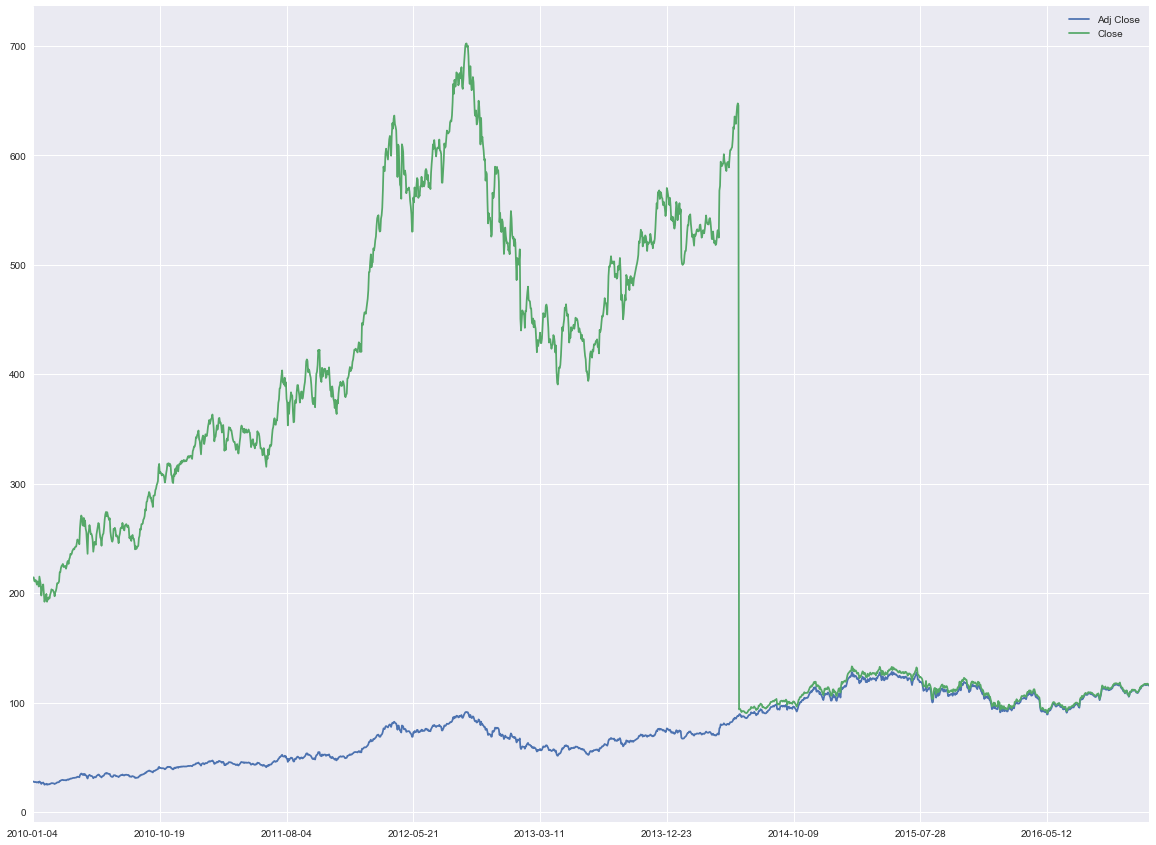

In [68]:
aapl_df.plot(figsize=(20,15))

# Load articles

In [51]:
from pymongo import MongoClient

In [52]:
client = MongoClient('localhost', 27017)
fomc_collection = client.python_import.fomc_articles

In [53]:
fomc_articles = pd.DataFrame(list(fomc_collection.find()))
fomc_articles.set_index('_id', inplace=True)

# Merge articles and actors score

In [54]:
fomc_articles_scored = fomc_articles.merge(actors, left_on='ParticipantName', right_index=True)
fomc_articles_scored.head(2)

,ParticipantJobTitle,ParticipantLocation,ParticipantName,ParticipantTitleLastName,ParticipantUrl,RemarkDate,RemarkDescription,RemarkType,content,date,url,Name,Score
_id,,,,,,,,,,,,,
58cab2973740f50f2c6fdccb,Pres.,Richmond,Jeffrey Lacker,Pres. Lacker,/fomcspeak/jeffrey-lacker,"Dec. 03, 2013",Lacker Testifies on Bankruptcy and Financial I...,Testimony,Good morning. I am honored to speak to the Sub...,2013-12-03 00:00:00,https://www.richmondfed.org/press_room/speeche...,Jeffrey M. Lacker,2
58cab29e3740f50f2c6fdcce,Pres.,Richmond,Jeffrey Lacker,Pres. Lacker,/fomcspeak/jeffrey-lacker,"Apr. 18, 2013 (8:06 AM ET)",Fed's Lacker Would End QE Now,Video Interview,Fed's Lacker Would End QE Now\n\t\t\t\t\n In a...,2013-04-18 08:06:00,http://video.cnbc.com/gallery/?video=3000162414,Jeffrey M. Lacker,2


# Number of articles in each score class

In [55]:
fomc_articles_scored.groupby('Score')['url'].count()

Score
-2    148
-1    168
 1    150
 2     72
Name: url, dtype: int64

# Create train data and test data

In [56]:
train_data = fomc_articles_scored[fomc_articles_scored['date'] < datetime(2016, 6, 1)]
test_data = fomc_articles_scored[fomc_articles_scored['date'] >= datetime(2016, 6, 1)]

In [57]:
X_train = train_data['content']
y_train = train_data['Score']
X_test = test_data['content']
y_test = test_data['Score']

# Tf-Idf and LogisticRegression model

### GridSearch on pipeline - it takes 20+ minutes on my machine!!!!!!!
###### http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html

In [12]:
pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('logreg_model', LogisticRegression())
])
#pipeline.fit(X_train, y_train)

params = dict(bow__ngram_range=[(1,1), (1,2), (1,3)],
              bow__max_df=np.arange(0.1,0.4,0.1),
              bow__min_df=[2,3,4],
              logreg_model__C=np.arange(0.5, 1.5, 0.3))
grid_search = GridSearchCV(pipeline, 
                           param_grid=params, 
                           verbose=3, 
                           scoring='precision_macro', 
                           n_jobs=8,
                           refit=True,
                           cv=5)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   15.7s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  7.0min
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed: 13.6min
[Parallel(n_jobs=8)]: Done 720 out of 720 | elapsed: 20.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        s...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=8,
       param_grid={'bow__ngram_range': [(1, 1), (1, 2), (1, 3)], 'bow__max_df': array([ 0.1,  0.2,  0.3,  0.4]), 'bow__min_df': [2, 3, 4], 'logreg_model__C': array([ 0.5,  0.8,  1.1,  1.4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision_macro', verbose=3)

In [13]:
grid_search.best_params_

{'bow__max_df': 0.40000000000000002,
 'bow__min_df': 3,
 'bow__ngram_range': (1, 2),
 'logreg_model__C': 1.1000000000000001}

In [14]:
grid_search.best_score_

0.85486294717787159

### Fitting the model

In [58]:
pipeline = Pipeline([
    ('bow', CountVectorizer(stop_words='english', max_df=0.4, min_df=3, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('bayes_model', LogisticRegression(C=1.1))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=None, min_df=3,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        s...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [59]:
y_predicted = pipeline.predict(X_test)

#### Confusion matrix
By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

In [60]:
cm = confusion_matrix(y_test, y_predicted)

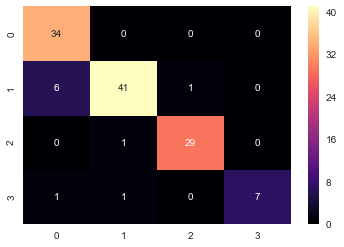

In [61]:
sns.heatmap(cm, cmap='magma', annot=True)

In [62]:
cr = classification_report(y_test, y_predicted)
print(cr)

             precision    recall  f1-score   support

         -2       0.83      1.00      0.91        34
         -1       0.95      0.85      0.90        48
          1       0.97      0.97      0.97        30
          2       1.00      0.78      0.88         9

avg / total       0.93      0.92      0.92       121



# Examine false classifications

In [63]:
test_data['Classified Score'] = y_predicted

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [64]:
false_classifications = test_data[y_test != y_predicted]

In [65]:
false_classifications.drop(false_classifications.columns[[0,1,3,4,5,6,7]], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [67]:
false_classifications

,ParticipantName,content,date,url,Name,Score,Classified Score
_id,,,,,,,
58cab4283740f50f2c6fe00d,Jeffrey Lacker,Download MP3\n Thank you for the invitation to...,2016-09-02 01:00:00,https://www.richmondfed.org/press_room/speeche...,Jeffrey M. Lacker,2,-2
58cab45e3740f50f2c6fe07e,Jeffrey Lacker,I’d like to thank the organizers for the oppor...,2017-03-03 10:15:00,https://www.richmondfed.org/press_room/speeche...,Jeffrey M. Lacker,2,-1
58cab42b3740f50f2c6fe014,Janet Yellen,,2016-09-21 02:00:00,https://www.federalreserve.gov/monetarypolicy/...,"Janet L. Yellen, Chair",-1,-2
58cab42d3740f50f2c6fe01b,Janet Yellen,"Chairman Hensarling, Ranking Member Waters, an...",2016-09-28 10:00:00,https://www.federalreserve.gov/newsevents/test...,"Janet L. Yellen, Chair",-1,-2
58cab43d3740f50f2c6fe057,James Bullard,Strong Banks. Strong Communities. Strong Econo...,2016-09-28 10:15:00,https://www.stlouisfed.org/from-the-president/...,James Bullard,1,-1
58cab42a3740f50f2c6fe011,Patrick Harker,Transforming Our Economies\n Transforming Our...,2016-09-23 12:20:00,https://www.philadelphiafed.org/publications/s...,Patrick Harker,-1,-2
58cab4303740f50f2c6fe02c,Patrick Harker,A Shot in the Arm: Stimulating the American Wo...,2016-10-13 12:15:00,https://www.philadelphiafed.org/publications/s...,Patrick Harker,-1,-2
58cab4363740f50f2c6fe044,Patrick Harker,Central Banking and Its Discontents?,2016-11-16 05:30:00,https://www.philadelphiafed.org/publications/s...,Patrick Harker,-1,-2
58cab45b3740f50f2c6fe064,Patrick Harker,Benjamin Franklin Birthday Celebration,2017-01-13 09:30:00,https://www.philadelphiafed.org/publications/s...,Patrick Harker,-1,-2


In [78]:
for index, row in false_classifications.iterrows():
    file_name = '{}__{}__{}__{}'.format(row['ParticipantName'], row['date'].date(), row['Score'], row['Classified Score'])
    full_name = './logreg_false_classifications/' + file_name + '.txt'
    with open(file=full_name, mode='x', encoding='utf-8') as f:
        f.write(row['content'])